<a href="https://colab.research.google.com/github/AgustinGurvich/TMD/blob/main/TMD_TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports


In [ ]:
install.packages("randomForest", dependencies = T)
library(randomForest)
install.packages("kernlab", dependencies = T)
library(kernlab)
library(MASS)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Estimaciones de error

In [ ]:
#---------------------------------------------------------------------------
#random forest error estimation (OOB) for greedy search
#---------------------------------------------------------------------------
rf.est <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))
	return( randomForest(x.train,y,mtry=mtry,ntree=tot.trees,sampsize=prop.samples)$err.rate[tot.trees] )
}

#---------------------------------------------------------------------------
#LDA error estimation (LOO) for greedy search
#---------------------------------------------------------------------------
lda.est <- function(x.train,y)
{
	m.lda <- lda(x.train,y,CV=TRUE)
	return(error.rate( y , m.lda$class))
}
error.rate <- function(dataA, dataB) sum( dataA != dataB ) / length(dataB)

#---------------------------------------------------------------------------
#SVM error estimation (internal CV) for greedy search
#---------------------------------------------------------------------------
svm.est <- function(x.train,y,type="C-svc",kernel="vanilladot",C=1,cross = 4)
{
	return ( ksvm(x.train, y, type=type,kernel=kernel,C=C,cross = cross)@cross )
}

#---------------------------------------------------------------------------
#random forest ranking method for rfe.
#---------------------------------------------------------------------------
imp.rf <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))
	
	m.rf<-randomForest(x.train,y,ntree=tot.trees,mtry=mtry,sampsize=prop.samples,importance=TRUE)
	imp.mat<-importance(m.rf)
	imp.col<-dim(imp.mat)[2]-1
	rank.list<-sort(imp.mat[,imp.col],decreasing=FALSE,index=T)
	return(list(feats=rank.list$ix,imp=rank.list$x))
}


#---------------------------------------------------------------------------
#linear svm ranking method for rfe. Using kernlab. Multiclass
#---------------------------------------------------------------------------
imp.linsvm <- function(x.train,y,C=100)
{
	num.feat<-dim(x.train)[2]
	tot.problems<-nlevels(y)*(nlevels(y)-1)/2

	m.svm <- ksvm(as.matrix(x.train), y, type="C-svc",kernel="vanilladot",C=C)

	w<-rep(0.0,num.feat)
	for(i in 1:tot.problems) for(feat in 1:num.feat)
		w[feat]<-w[feat]+abs(m.svm@coef[[i]] %*% m.svm@xmatrix[[i]][,feat])
	rank.list<-sort(w,decreasing=FALSE,index=T)
	return(list(feats=rank.list$ix,imp=rank.list$x))
}


Codigo para el wrapper greedy forward

In [ ]:
#-------------------------------------------------------------------------------------
# AVISO: este codigo esta adaptado de un paquete mayor. 
# No es optimo y tiene cosas inutiles para nosotros. Es un ejemplo nada mas
#
#general forward greedy selection function
#input:
# x,y inputs and targets
# method is an external function that estimates classification error with a given model
# ... parameters for method
#output:
#ordered.names.list <- nombre de las variables ordenadas de la mas importante a la menos
#ordered.features.list <-numero de orden inicial de las variables, con el mismo orden
#importance <- importancia de cada variables en el mismo orden

#-------------------------------------------------------------------------------------
forward.ranking <- function(x,y,method,verbosity=0,... )
{

	max.feat<-dim(x)[2] #Cantidad de variables (digamosle k)
	num.feat<-1 #Cantidad inicial de variables
	list.feat<-1:max.feat #Sequencia de 1 a k donde guardo las variables mas importantes

	#ranking inicial: elijo la variable con menor error de prediccion
  x.train<-matrix(0,dim(x)[1],1) #Columna de 0 de tamaño n 
	class.error<-double(max.feat) #Aca voy a guardar todos los errores
	#para cada i, creo el dataset con esa variable sola, entreno un modelo y le mido el error, que lo guardo en class.error[i]
	for(i in 1:max.feat){
		x.train[,1]<-x[,i] #Lleno la variable donde guardo los datos de train con la columna de la variable que me importa
		class.error[i] <- do.call(method, c(list(as.matrix(x.train), y), list(...)) ) # Entreno un modelo y guardo el error
	}
	#guardo la variable con minimo error como primera. Guardo una lista keep.feat con las que me quedan para seguir eligiendo.
	list.feat[1]<-which.min(class.error) #Aca quedan ordenadas por importancia
	keep.feat<-sort(class.error,decreasing=FALSE,index=T)$ix[-1] #Aca quedan las que tengo que probar
	#armo un dataset con las variables que ya elegi, para ir agregando en cada paso.
	x.prev<-x.train[,1]<-x[,list.feat[1]] #En x.train pongo la variable importante como columna, y guardo esa columna como variable en x.prev

	if(verbosity>1) cat("\nFirst feature: ",list.feat[1],"\n")

    #loop principal. A cada paso agrego todas las variables disponibles, de a una, le mido el error y me quedo con la de minimo error. Hasta llegar a meter todas.
	while(num.feat<max.feat){
    #class.error guarda el error de cada modelo. Son max.feat-num.feat modelos.
		class.error<-double(max.feat-num.feat) #Voy sacando features
		#para cada variable que me queda, la agrego al dataset del paso anterior, entreno el modelo y le mido el error.
		for(i in 1:(max.feat-num.feat)){
			x.train<-cbind(x.prev,x[,keep.feat[i]]) #En x.prev estaban las variables que me servian, le agrego como columna la nueva variable 
			class.error[i] <- do.call(method, c(list(as.matrix(x.train), y), list(...)) )
		}
		if(verbosity>2) cat("\nFeatures:\n",keep.feat,"\nErrors:\n",class.error)
		#me quedo con el modelo de minimo error, guardo ese feature en la lista de las elegidas, lo saco de la lista de las que quedan, y actualizo el dataset de partida de la iteracion.
		best.index<-which.min(class.error)
		list.feat[num.feat+1]<-keep.feat[best.index]
		if(verbosity>1) cat("\n---------\nStep ",1+num.feat,"\nFeature ",best.index)

		keep.feat<-keep.feat[-best.index]
		if(verbosity>2) cat("\nNew search list: ",keep.feat)
		num.feat<-num.feat+1
		x.prev<-x[,list.feat[1:num.feat]] #Como en list.feat estaban las que me servian, ordenadas, las guardo en x.prev
	}

	print(list.feat)
	search.names<-colnames(x)[list.feat]
	#le asigno a cada feature una importacia proporcional al orden en que lo seleccionamos
	imp<-(max.feat:1)/max.feat
	names(imp)<-search.names

	if(verbosity>1){
		cat("\n---------\nFinal ranking ",num.feat," features.")
		cat("\nFeatures: ",search.names,"\n")
	}

 	return( list(ordered.names.list=search.names,ordered.features.list=list.feat,importance=imp) )

}

Codigo para el wrapper greedy backward

In [ ]:
backward.ranking <- function(data, classes, method, ...){
	feature_amount = dim(data)[2]
	feature_list = 1 : feature_amount
	# Lista donde se guardarán los features en orden de eliminación.
	feature_removal_order = double(feature_amount)
	  
	# Iteraremos hasta haber eliminado todos los features excepto uno.
	while(length(feature_list) > 1){
		# Almacenaremos tantas estimaciones de error como features nos queden en la iteración.
		error_estimations = double(length(feature_list))
		# Por cada feature que nos queda, estimaremos el error de entrenar un método usando
		# todos los demás menos él.
		for(feature_index in 1 : length(feature_list)){
			training_data = as.matrix(data[, feature_list[-feature_index]])
			error_estimations[feature_index] = do.call(method, c(list(training_data, classes), list(...)))
		}
		
		# Eliminamos el feature que, al entrenar sin él, nos resulta en el error mínimo
		# entre todas las opciones.
		feature_to_remove = which.min(error_estimations)
		feature_removal_order[length(feature_list)] = feature_list[feature_to_remove]
		feature_list = feature_list[- feature_to_remove]
	}
	
	# El último feature en eliminar es el que haya quedado de las iteraciones anteriores.
	feature_removal_order[1] = feature_list[1]
	
	# Luego, preparamos la información para que se devuelva con el mismo formato que 
	# tiene el método de base que estaba dado.
	feature_names = colnames(data)[feature_removal_order]
	importance = (feature_amount : 1) / feature_amount
	names(importance) = feature_names
	
 	return(list(ordered.names.list = feature_names, 
 	            ordered.features.list = feature_removal_order, 
 	            importance = importance))
}

Codigo para el filter con test no-paramétrico

In [ ]:
no.parametrico <- function(x,y){
  var.count <- dim(x)[2]
  stat <- c()
  for (i in 1:var.count){
    var<-x[,i]
    stat[i] <- kruskal.test(var,y)$statistic
  }
  ordered.vars <- order(stat, decreasing=T) 
  var.names<-colnames(x)[ordered.vars]
  imp<-(var.count:1)/var.count
	names(imp)<-var.names
  return( list(ordered.names.list=var.names,ordered.features.list=ordered.vars,importance=imp) )

}

Codigo para el RFE

In [ ]:
rfe <- function(x,y,method,...){
  p <- dim(x)[2]
  F <- 1:p #Todas mis variables
  R <- c()
  for(i in 1:p){
    #Truco que me sirvio para entender que estoy haciendo al construir el dataset de entrenamiento:
    #F es una lista de indices (guarda todas las variables que voy a usar)
    #En lugar de hacer algun truco raro para llevar registro de que voy eliminando, reconstruyo el dataset de entrenamiento con los indices
    x.train <- as.matrix(x[,F]) #Tengo que pasarlo a matrix porque sino tengo problemas con las dimensiones
    values <- do.call(method, c(list(x.train, y), list(...)) ) 
    fIndex <- values$feats[1] #Obtengo la variable menos importante
    R[p-i+1] <- F[fIndex] #Agrego la variable menos importante
    F <- F[-fIndex] #Elimino la variable de mi lista de variables
  }
  var.names<-colnames(x)[R]
  imp<-(p:1)/p
	names(imp)<-var.names
  return( list(ordered.names.list=var.names,ordered.features.list=R,importance=imp) )

}

Aplicamos cada analisis

In [ ]:
#demo: aplicar el wrapper a los datos de iris
data(iris)

In [ ]:
FORW.rf <-forward.ranking(iris[,-5],iris[,5],method="rf.est" ,tot.trees=100,equalize.classes=F)
FORW.lda<-forward.ranking(iris[,-5],iris[,5],method="lda.est")
print(FORW.rf)
print(FORW.lda)

[1] 4 3 1 2
[1] 4 3 1 2
$ordered.names.list
[1] "Petal.Width"  "Petal.Length" "Sepal.Length" "Sepal.Width" 

$ordered.features.list
[1] 4 3 1 2

$importance
 Petal.Width Petal.Length Sepal.Length  Sepal.Width 
        1.00         0.75         0.50         0.25 

$ordered.names.list
[1] "Petal.Width"  "Petal.Length" "Sepal.Length" "Sepal.Width" 

$ordered.features.list
[1] 4 3 1 2

$importance
 Petal.Width Petal.Length Sepal.Length  Sepal.Width 
        1.00         0.75         0.50         0.25 



In [ ]:
BACK.rf <-backward.ranking(iris[,-5],iris[,5],method="rf.est" ,tot.trees=100,equalize.classes=F)
print(BACK.rf)
BACK.lda<-backward.ranking(iris[,-5],iris[,5],method="lda.est")
print(BACK.lda)

$ordered.names.list
[1] "Petal.Width"  "Petal.Length" "Sepal.Width"  "Sepal.Length"

$ordered.features.list
[1] 4 3 2 1

$importance
 Petal.Width Petal.Length  Sepal.Width Sepal.Length 
        1.00         0.75         0.50         0.25 

$ordered.names.list
[1] "Petal.Width"  "Petal.Length" "Sepal.Length" "Sepal.Width" 

$ordered.features.list
[1] 4 3 1 2

$importance
 Petal.Width Petal.Length Sepal.Length  Sepal.Width 
        1.00         0.75         0.50         0.25 



In [ ]:
noP <- no.parametrico(iris[,-5],iris[,5])
print(noP)

$ordered.names.list
[1] "Petal.Width"  "Petal.Length" "Sepal.Length" "Sepal.Width" 

$ordered.features.list
[1] 4 3 1 2

$importance
 Petal.Width Petal.Length Sepal.Length  Sepal.Width 
        1.00         0.75         0.50         0.25 



In [ ]:
RFE.rf <- rfe(iris[,-5],iris[,5],method="imp.rf",tot.trees=100,equalize.classes=F)
print(RFE.rf)
RFE.linsvm <- rfe(iris[,-5],iris[,5],method="imp.linsvm")
print(RFE.linsvm)

$ordered.names.list
[1] "Petal.Length" "Petal.Width"  "Sepal.Length" "Sepal.Width" 

$ordered.features.list
[1] 3 4 1 2

$importance
Petal.Length  Petal.Width Sepal.Length  Sepal.Width 
        1.00         0.75         0.50         0.25 

 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
$ordered.names.list
[1] "Petal.Length" "Petal.Width"  "Sepal.Length" "Sepal.Width" 

$ordered.features.list
[1] 3 4 1 2

$importance
Petal.Length  Petal.Width Sepal.Length  Sepal.Width 
        1.00         0.75         0.50         0.25 



In [ ]:
crea.ruido.unif<-function(n=100,d=2){
  x<-runif(2*n*d,min=-1)	#genero los datos
  dim(x)<-c(2*n,d)
  return(cbind(as.data.frame(x),y=factor(rep(c(-1,1),each=n))))	#le agrego la clase
}

Aplicamos los metodos de seleccion de variables sobre datosA

In [ ]:
#datosA
d<-10
n<-1000
datos<-crea.ruido.unif(n=n,d=d)

#tomar 50% de los datos al azar, y hacer que la clase sea el signo de la 8 variable
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,d+1]<-sign(datos[sub,8])
#tomar 20% de los datos al azar (fuera de los anteriores), y hacer que la clase sea el signo de la 6 variable
sub<-shuffle[(dim(datos)[1]*0.5):(dim(datos)[1]*0.7)]
datos[sub,d+1]<-sign(datos[sub,6])
#tomar 10% de los datos al azar, y hacer que la clase sea el signo de la 4 variable
sub<-shuffle[(dim(datos)[1]*0.7):(dim(datos)[1]*0.8)]
datos[sub,d+1]<-sign(datos[sub,4])
#tomar 5% de los datos al azar, y hacer que la clase sea el signo de la 2 variable
sub<-shuffle[(dim(datos)[1]*0.8):(dim(datos)[1]*0.85)]
datos[sub,d+1]<-sign(datos[sub,2])
datos[,d+1]<-factor(datos[,d+1])

datosA<-datos

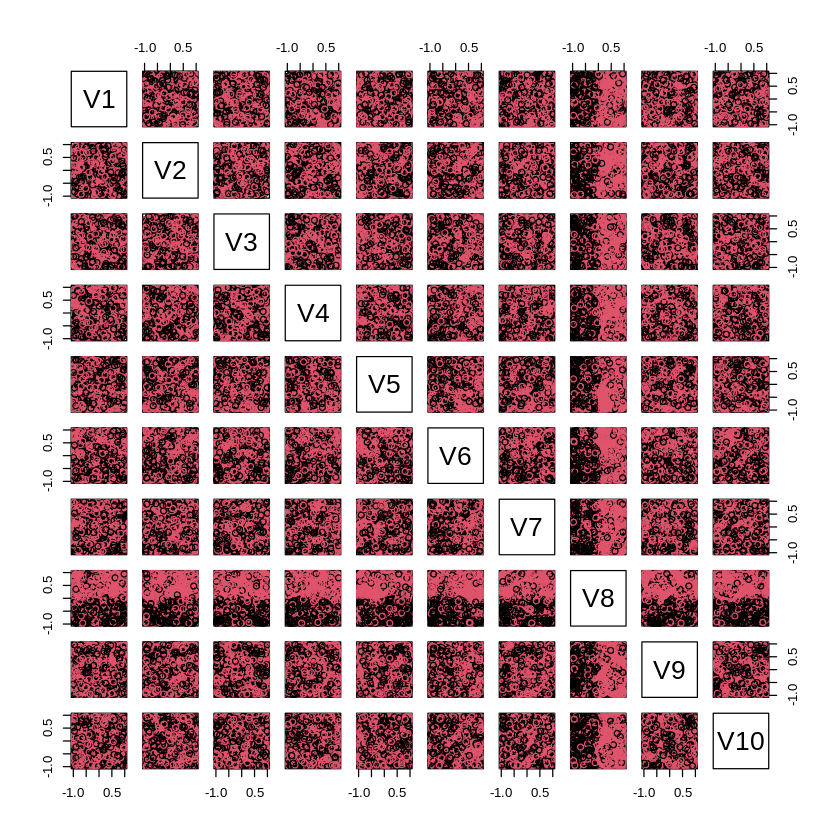

In [ ]:
plot(datosA[,-11],col=datosA[,11])

In [ ]:
print("Metodos de forward wrapper")
invisible(capture.output(datosA.FORW.svm<-forward.ranking(datosA[,-11],datosA[,11],method="svm.est",)))
print("Resultado con FORW.svm")
print(datosA.FORW.svm$importance)
datosA.FORW.rf <-forward.ranking(datosA[,-11],datosA[,11],method="rf.est" ,tot.trees=100,equalize.classes=F)
print("Resultado con FORW.rf")
print(datosA.FORW.rf$importance)
datosA.FORW.lda<-forward.ranking(datosA[,-11],datosA[,11],method="lda.est")
print("Resultado con FORW.lda")
print(datosA.FORW.lda$importance)

print("Metodos de backward wrapper")
invisible(capture.output(datosA.BACK.svm<-backward.ranking(datosA[,-11],datosA[,11],method="svm.est")))
print("Resultado con BACK.svm")
print(datosA.FORW.svm$importance)
datosA.BACK.rf <-backward.ranking(datosA[,-11],datosA[,11],method="rf.est" ,tot.trees=100,equalize.classes=F)
print("Resultado con BACK.rf")
print(datosA.BACK.rf$importance)
datosA.BACK.lda<-backward.ranking(datosA[,-11],datosA[,11],method="lda.est")
print("Resultado con BACK.lda")
print(datosA.BACK.lda$importance)

print("Test no parametrico")
datosA.noP <- no.parametrico(datosA[,-11],datosA[,11])
print("Resultado con noP")
print(datosA.noP$importance)

print("Metodos de RFE")
datosA.RFE.rf <- rfe(datosA[,-11],datosA[,11],method="imp.rf",tot.trees=100,equalize.classes=F)
print("Resultado con RFE.rf")
print(datosA.RFE.rf$importance)
invisible(capture.output(datosA.RFE.linsvm <- rfe(datosA[,-11],datosA[,11],method="imp.linsvm")))
print("Resultado con RFE.linsvm")
print(datosA.RFE.linsvm$importance)

[1] "Metodos de forward wrapper"
[1] "Resultado con FORW.svm"
 V8  V5  V2 V10  V7  V1  V9  V3  V4  V6 
1.0 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.2 0.1 
 [1]  8  5  9  3  7  1  2  4 10  6
[1] "Resultado con FORW.rf"
 V8  V5  V9  V3  V7  V1  V2  V4 V10  V6 
1.0 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.2 0.1 
 [1]  8  3  7  2  5 10  1  9  4  6
[1] "Resultado con FORW.lda"
 V8  V3  V7  V2  V5 V10  V1  V9  V4  V6 
1.0 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.2 0.1 
[1] "Metodos de backward wrapper"
[1] "Resultado con BACK.svm"
 V8  V5  V2 V10  V7  V1  V9  V3  V4  V6 
1.0 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.2 0.1 
[1] "Resultado con BACK.rf"
 V8  V6  V4  V7  V2  V5  V3  V1  V9 V10 
1.0 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.2 0.1 
[1] "Resultado con BACK.lda"
 V8  V3  V7  V5 V10  V2  V9  V1  V4  V6 
1.0 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.2 0.1 
[1] "Test no parametrico"
[1] "Resultado con noP"
 V8  V6  V4  V1  V9 V10  V3  V2  V5  V7 
1.0 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.2 0.1 
[1] "Metodos de RFE"
[1] "Resultado con RFE.rf"
 V8  V6  V4  V3  V9

Todos los tests coinciden que la variable más importante es V8, lo cual tiene sentido pues determina el signo del 50% de los datos.

El test no parametrico y RFE ponen como segunda variable importante a V6, pero los otros metodos la colocan cerca del final (excepto backward con random forest). Si bien V6 determina el 20% de los datos, creo que se puede deber a la forma en la que se construyó el dataset. Probablemente la muestra que generé está distribuida de forma tal que V7 también determine cerca del 20% de los datos.

In [ ]:
Aplicamos los metodos de seleccion de variables sobre datosB

In [ ]:
#datosB
#generar n=100,d=8
d<-8
n<-1000
datos<-crea.ruido.unif(n=n,d=d)
#hacer que la clase sea el xor de las 2 primeras variables (es usando el signo)
datos[,d+1]<-sign(datos[,1]*datos[,2])
#hacer que las variables 3 y 4 tengan un 50% de correlacion con la clase
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,3]<-abs(datos[sub,3])*datos[sub,d+1]
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,4]<-abs(datos[sub,4])*datos[sub,d+1]
datos[,d+1]<-factor(datos[,d+1])

datosB<-datos

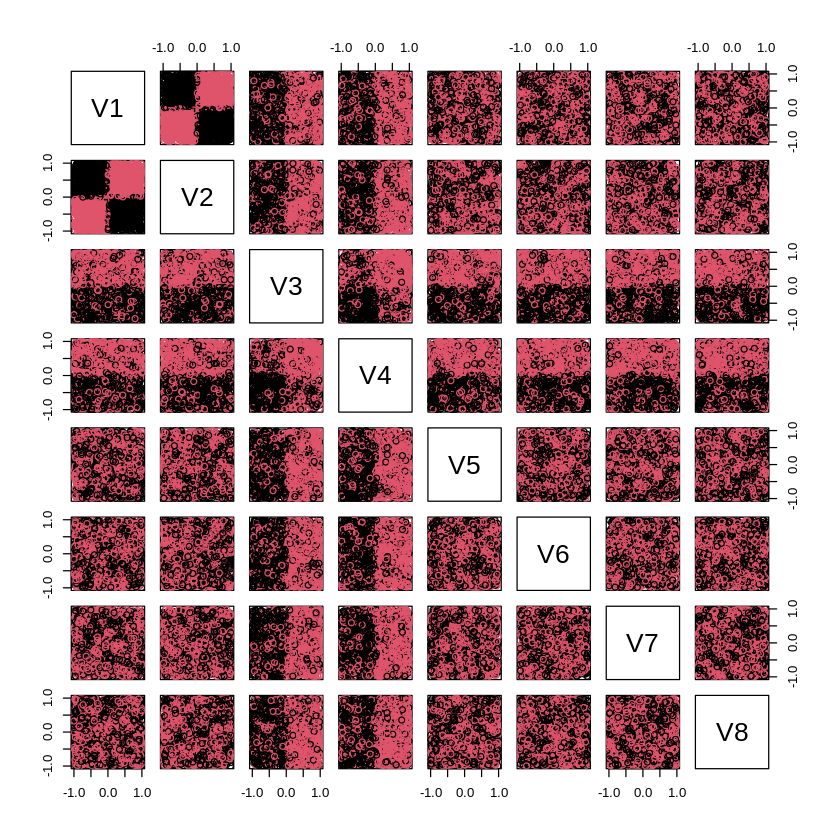

In [ ]:
plot(datosB[,-9],col=datosB[,9])

In [ ]:
print("Metodos de forward wrapper")
invisible(capture.output(datosB.FORW.svm<-forward.ranking(datosB[,-9],datosB[,9],method="svm.est",)))
print("Resultado con FORW.svm")
print(datosB.FORW.svm$importance)
datosB.FORW.rf <-forward.ranking(datosB[,-9],datosB[,9],method="rf.est" ,tot.trees=100,equalize.classes=F)
print("Resultado con FORW.rf")
print(datosB.FORW.rf$importance)
datosB.FORW.lda<-forward.ranking(datosB[,-9],datosB[,9],method="lda.est")
print("Resultado con FORW.lda")
print(datosB.FORW.lda$importance)

print("Metodos de backward wrapper")
invisible(capture.output(datosB.BACK.svm<-backward.ranking(datosB[,-9],datosB[,9],method="svm.est")))
print("Resultado con BACK.svm")
print(datosB.FORW.svm$importance)
datosB.BACK.rf <-backward.ranking(datosB[,-9],datosB[,9],method="rf.est" ,tot.trees=100,equalize.classes=F)
print("Resultado con BACK.rf")
print(datosB.BACK.rf$importance)
datosB.BACK.lda<-backward.ranking(datosB[,-9],datosB[,9],method="lda.est")
print("Resultado con BACK.lda")
print(datosB.BACK.lda$importance)

print("Test no parametrico")
datosB.noP <- no.parametrico(datosB[,-9],datosB[,9])
print("Resultado con noP")
print(datosB.noP$importance)

print("Metodos de RFE")
datosB.RFE.rf <- rfe(datosB[,-9],datosB[,9],method="imp.rf",tot.trees=100,equalize.classes=F)
print("Resultado con RFE.rf")
print(datosB.RFE.rf$importance)
invisible(capture.output(datosB.RFE.linsvm <- rfe(datosB[,-9],datosB[,9],method="imp.linsvm")))
print("Resultado con RFE.linsvm")
print(datosB.RFE.linsvm$importance)

[1] "Metodos de forward wrapper"
[1] "Resultado con FORW.svm"
   V3    V4    V7    V1    V8    V2    V6    V5 
1.000 0.875 0.750 0.625 0.500 0.375 0.250 0.125 
[1] 4 3 7 1 2 8 6 5
[1] "Resultado con FORW.rf"
   V4    V3    V7    V1    V2    V8    V6    V5 
1.000 0.875 0.750 0.625 0.500 0.375 0.250 0.125 
[1] 3 4 1 5 8 6 2 7
[1] "Resultado con FORW.lda"
   V3    V4    V1    V5    V8    V6    V2    V7 
1.000 0.875 0.750 0.625 0.500 0.375 0.250 0.125 
[1] "Metodos de backward wrapper"
[1] "Resultado con BACK.svm"
   V3    V4    V7    V1    V8    V2    V6    V5 
1.000 0.875 0.750 0.625 0.500 0.375 0.250 0.125 
[1] "Resultado con BACK.rf"
   V1    V2    V8    V7    V6    V5    V4    V3 
1.000 0.875 0.750 0.625 0.500 0.375 0.250 0.125 
[1] "Resultado con BACK.lda"
   V3    V4    V1    V6    V7    V5    V2    V8 
1.000 0.875 0.750 0.625 0.500 0.375 0.250 0.125 
[1] "Test no parametrico"
[1] "Resultado con noP"
   V3    V4    V2    V6    V5    V1    V8    V7 
1.000 0.875 0.750 0.625 0.500 0.37

Los datos tienen su clase determinada por un xor entre V1 y V2, por lo que no resulta sorprendente que en algunos métodos ambas variables tengan un ranking bastante alto.

Por otro lado, en base a unas trampitas, V3 y V4 están correlacionadas un 50% con la clase, por lo que se explican los resultados de ambas variables estando bastante alto en los rankings.

Codigo para el dataset diagonal

In [ ]:
diagonal <- function(n,d,C){
std_dev <- C * sqrt(d) 
covariance_matrix = diag(std_dev, d, d)
centerClass1 <- rep(1, times=d)
centerClass0 <- rep(-1, times=d)
size1 <- floor(n/2)
size0 <- ceiling(n/2)
points1 <- mvrnorm(size1, centerClass1, covariance_matrix)
points0 <- mvrnorm(size0, centerClass0, covariance_matrix)
class1 <- cbind(points1, rep(1, times=d))
class0 <- cbind(points0, rep(0, times=d))
columnNames <- c(paste0("V", seq(1,d)),"class")
f <- as.data.frame(rbind(class0,class1))
colnames(f) <- columnNames
return (f)
}

datosDiagonal <- diagonal(100,10,2) #Genero los datos de 10 variables
clase <- datosDiagonal[,11] #Guardo las clases originales
ruido <- crea.ruido.unif(100,90)[,-91] #Genero el ruido y le saco la clase
dataAConstruir <- cbind(datosDiagonal[,-11],ruido) #Agrando el dataset
datosDiagonal <- cbind(dataAConstruir, clase) #Le devuelvo la clase

In [ ]:
#No se puede correr porque no entra la imagen
plot(datosDiagonal[,-11],col=datosDiagonal[,11])

ERROR: ignored

In [ ]:
calcular.cantidad.originales <- function(ranking){
  primeras.diez <- ranking$ordered.features.list[1:10]
  return (length(primeras.diez[primeras.diez <= 10]))
}


[1]  9  7 10  1  3 19  4  8  6 20

[1] 8